# Transfer Learning with MobileNetV2

## Imports

In [1]:
from pathlib import Path

from typing import Optional

import torch
from torch import nn
from torch.optim.optimizer import Optimizer
from torch.optim.adam import Adam
from torch.utils.data import DataLoader, random_split

import torchvision

from torch.utils.tensorboard.writer import SummaryWriter

from tabulate import tabulate

import kagglehub

from matplotlib import pyplot as plt
import numpy as np

from torchinfo import summary

## Functions

In [2]:
def find_device() -> str:
    """Find the available device

    :return: Available device
    :rtype: str
    """
    device = "cpu"

    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"

    return device


def find_machine() -> str:
    """find the current machine between [PC, COLAB, KAGGLE]

    :return: current machine
    :rtype: str
    """

    result = "PC"

    try:
        import google.colab  # type: ignore

        result = "COLAB"
    except ImportError:
        pass

    try:
        import kaggle_environment  # type: ignore

        result = "KAGGLE"
    except ImportError:
        pass

    return result


def load_data(
    data_path: Path,
    batch_size=32,
) -> tuple[DataLoader, DataLoader, DataLoader]:
    """load data in an appropriate way for training, validation and testing.

    :param data_path: Path to the data folder.
    :type data_path: Path
    :return: train, validation, test
    :rtype: Tuple[DataLoader, DataLoader, DataLoader]
    """
    tr = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize([90, 160]),
            torchvision.transforms.ToTensor(),
        ]
    )

    image_folder = torchvision.datasets.ImageFolder(data_path, transform=tr)  # type: ignore

    g1 = torch.Generator().manual_seed(20)
    train_data, val_data, test_data = random_split(image_folder, [0.6, 0.2, 0.2], g1)

    train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_data_loader, val_data_loader, test_data_loader


def load_model(device: str) -> nn.Module:
    """Load the model

    :param device: availble device to use
    :type device: str
    :return: Loaded model
    :rtype: nn.Module
    """
    model = torchvision.models.mobilenet_v2(
        weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1
    )
    for param in model.parameters():
        param.requires_grad = False

    model.classifier[1] = nn.Linear(1280, 4)
    model = model.to(device)

    return model


def train(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: nn.Module,
    optimizer: Optimizer,
    device: str = "cuda",
    tensorboard_writer: Optional[SummaryWriter] = None,
    epoch: int = 0,
):
    """Train the model

    :param model: model to train
    :type model: nn.Module
    :param data_loader: data loader for the training
    :type data_loader: DataLoader
    :param loss_fn: loss function
    :type loss_fn: nn.Module
    :param optimizer: optimizer
    :type optimizer: Optimizer
    :param device: Available device, defaults to "cuda"
    :type device: str, optional
    :param tensorboard_writer: tensorboard writer, defaults to None
    :type tensorboard_writer: SummaryWriter, optional
    :param epoch: number of the current epoch to report, defaults to 0
    :type epoch: int, optional
    """
    model = model.to(device)
    model.train()

    running_loss = 0
    i_c = 0
    number_of_batches = len(data_loader)

    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        prediction = model(images)
        loss = loss_fn(prediction, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        i_c += 1
        if (i % 10 == 9) or i == number_of_batches - 1:
            print(f"\r{i + 1}/{number_of_batches}, loss = {loss.item():>4f}", end="")
            if tensorboard_writer:
                tensorboard_writer.add_scalar(
                    "training loss", running_loss / i_c, epoch * number_of_batches + i
                )
            running_loss = 0
            i_c = 0
    print()


def evaluate(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: nn.Module,
    device: str = "cuda",
) -> tuple[float, float]:
    """Evaluate the model on the given dataset.

    :param model: model to evaluate
    :type model: nn.Module
    :param data_loader: data loader to evaluate on
    :type data_loader: DataLoader
    :param loss_fn: loss function to use
    :type loss_fn: nn.Module
    :param device: available device, defaults to "cuda"
    :type device: str, optional
    :return: accuracy and average loss
    :rtype: tuple[float, float]
    """
    data_size = len(data_loader.dataset)  # type: ignore
    number_of_batches = len(data_loader)

    model.eval()

    loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            prediction = model(images)
            loss += loss_fn(prediction, labels).item()
            correct += (prediction.argmax(1) == labels).type(torch.float).sum().item()

        loss /= number_of_batches
        correct /= data_size

    return correct, loss


def plot_on_batch_of_data(
    data_loader: DataLoader,
    name="images",
) -> None:
    """Plot a batch of data

    :param data_loader: data loader to plot
    :type data_loader: DataLoader
    :param name: name of the plot, defaults to "images"
    :type name: str, optional
    """
    images, labels = next(iter(data_loader))

    batch_size = len(images)
    col_number = int(np.ceil(batch_size ** (1 / 2)))
    while batch_size % col_number != 0:
        col_number += 1

    row_number = batch_size // col_number
    fig, axes = plt.subplots(row_number, col_number)

    fig.suptitle(name)

    axes_ravel = axes.ravel()

    images, labels = next(iter(data_loader))

    for i, (image, label) in enumerate(zip(images, labels)):
        axes_ravel[i].imshow(torchvision.transforms.ToPILImage()(image))
        axes_ravel[i].set_axis_off()
        axes_ravel[i].set_title(f"{label}")

## Config

In [3]:
DEVICE = find_device()

CURRENT_MACHINE = find_machine()

config_data = [
    ["Device", DEVICE],
    ["Current Machine", CURRENT_MACHINE],
]

print(tabulate(config_data, headers=["Parameter", "Value"]))

Parameter        Value
---------------  -------
Device           mps
Current Machine  PC


## Tensorboard

In [4]:
if CURRENT_MACHINE != "KAGGLE":
    writer = SummaryWriter("runs/tom_and_jerry")

    %load_ext tensorboard
    %tensorboard --logdir runs

### Load data

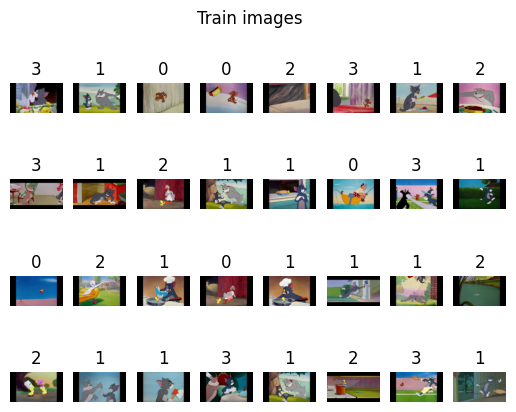

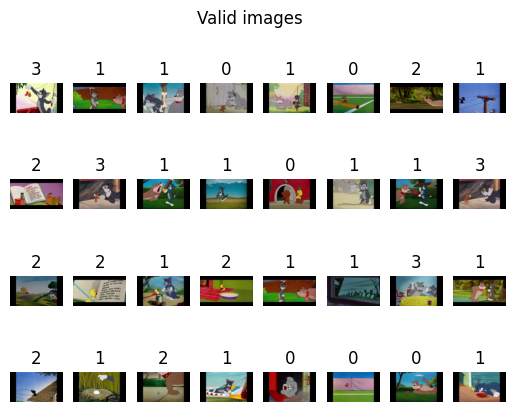

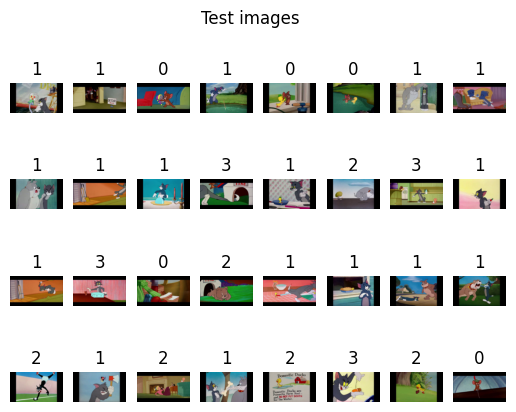

In [5]:
if CURRENT_MACHINE != "KAGGLE":
    path = Path(
        kagglehub.dataset_download("balabaskar/tom-and-jerry-image-classification")
    )
else:
    path = Path("../input/tom-and-jerry-image-classification/")

data_path = path / "tom_and_jerry/tom_and_jerry"

train_data_loader, val_data_loader, test_data_loader = load_data(data_path)

plot_on_batch_of_data(train_data_loader, "Train images")
plot_on_batch_of_data(val_data_loader, "Valid images")
plot_on_batch_of_data(test_data_loader, "Test images")

## define model

In [17]:
model = load_model(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

print(
    summary(
        model,
        (1, 3, 90, 160),
        col_names=("input_size", "output_size", "num_params", "trainable"),
    )
)

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
MobileNetV2                                        [1, 3, 90, 160]           [1, 4]                    --                        Partial
├─Sequential: 1-1                                  [1, 3, 90, 160]           [1, 1280, 3, 5]           --                        False
│    └─Conv2dNormActivation: 2-1                   [1, 3, 90, 160]           [1, 32, 45, 80]           --                        False
│    │    └─Conv2d: 3-1                            [1, 3, 90, 160]           [1, 32, 45, 80]           (864)                     False
│    │    └─BatchNorm2d: 3-2                       [1, 32, 45, 80]           [1, 32, 45, 80]           (64)                      False
│    │    └─ReLU6: 3-3                             [1, 32, 45, 80]           [1, 32, 45, 80]           --                        --
│    └─InvertedResidual: 2-2                       [

## train

In [18]:
%%time

for epoch in range(5):
    print(f"in epoch: {epoch}")
    train(model, train_data_loader, loss_fn, optimizer, DEVICE, writer, epoch)
    accuracy, loss = evaluate(model, val_data_loader, loss_fn, DEVICE)
    print(f"accuracy: {accuracy:.2f}, loss: {loss:.2f}")
    print("-" * 20)
    print()

in epoch: 0
103/103, loss = 0.961617
accuracy: 0.61, loss: 0.95
--------------------

in epoch: 1
103/103, loss = 0.964947
accuracy: 0.64, loss: 0.87
--------------------

in epoch: 2
103/103, loss = 0.719287
accuracy: 0.63, loss: 0.89
--------------------

in epoch: 3
103/103, loss = 1.061435
accuracy: 0.67, loss: 0.85
--------------------

in epoch: 4
103/103, loss = 0.972374
accuracy: 0.65, loss: 0.84
--------------------

CPU times: user 6min 28s, sys: 41.1 s, total: 7min 9s
Wall time: 1min 31s


## Test

In [19]:
accuracy, loss = evaluate(model, test_data_loader, loss_fn, DEVICE)
print("test results:")
print(f"accuracy: {accuracy}, loss: {loss}")

test results:
accuracy: 0.6557077625570776, loss: 0.8505963427679879
